In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time
from model import make_model

import config


np.set_printoptions(precision=4, suppress = True)

In [3]:
!pip install pyvirtualdisplay
!pip install Pillow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma

def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np.random.randn(*log_sigma.shape) 
    return z


def get_z_from_rnn_output(y_pred):
    HIDDEN_UNITS = 256
    GAUSSIAN_MIXTURES = 5
    Z_DIM = 32
    d = GAUSSIAN_MIXTURES * Z_DIM

    z_pred = y_pred[:(3*d)]
    rew_pred = y_pred[-1]

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    chosen_log_pi = np.zeros(Z_DIM)
    chosen_mu = np.zeros(Z_DIM)
    chosen_log_sigma = np.zeros(Z_DIM)

    # adjust temperatures
    logmix2 = np.copy(log_pi)
    logmix2 -= logmix2.max()
    logmix2 = np.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(Z_DIM, 1)


    for j in range(Z_DIM):
        idx = get_pi_idx(np.random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j, idx]
        chosen_log_sigma[j] = log_sigma[j,idx]

    next_z = sample_z(chosen_mu, chosen_log_sigma)

    # print(next_z)
    # print(rew_pred)
    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0
        
    return next_z, next_reward, chosen_mu

In [5]:
model = make_model()
model.make_env('car_racing')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
model.load_model('./controller/car_racing.cma.1.4.best.json')

loading file ./controller/car_racing.cma.1.4.best.json


In [7]:
z_weight = model.weight[0][:32,2]
h_weight = model.weight[0][32:,2]

In [8]:
z_weight

array([-0.7691, -2.6957, -1.4249, -0.6277,  0.3587,  1.2266, -0.0296,
       -0.0291, -0.8553,  0.3323,  1.1727, -2.7637, -0.0323,  0.5527,
        3.3359,  3.0493,  2.734 , -0.929 ,  2.7507,  1.7829,  0.5265,
        1.7421, -0.1321, -1.9283, -1.6895,  0.5035, -0.9036, -2.5185,
       -2.2768,  0.4289, -0.6876, -0.1834])

In [9]:
h_weight

array([-1.408 ,  1.6276, -1.3124,  2.1057, -1.3801,  0.8138, -2.394 ,
       -0.3932,  2.3084,  2.6212, -1.6004, -1.2853,  0.7256, -0.0405,
       -1.1943, -0.0738, -1.4291,  2.9602,  3.3585, -1.9429, -0.0427,
       -1.646 ,  0.4748,  1.0836, -0.6132,  0.5433, -0.4074, -0.6823,
        0.9523,  4.0934, -1.4465, -0.1795,  0.8405,  1.7609, -1.7586,
       -0.6016, -2.1248, -5.7801,  0.3799,  1.8721, -2.2134, -1.6271,
        0.1328,  2.0399,  1.528 , -0.4975, -0.2226, -0.3445, -0.1641,
        0.4613, -0.2541,  0.9299, -0.7501,  0.8577, -0.0926,  0.864 ,
        1.4289, -0.648 , -0.4099, -1.0063,  2.4065, -1.398 , -1.5282,
        0.6153,  1.0259, -2.6588,  1.3069,  2.8713,  2.0983, -1.6288,
       -1.6693,  0.6059,  1.1127, -1.3722, -0.1754,  2.4415,  0.3537,
       -2.3252, -0.8339, -1.3001, -1.5962,  0.2831,  1.77  , -1.383 ,
        1.2001, -0.5009,  1.0554,  1.6788,  0.1015, -1.9688, -1.4488,
       -0.7574,  0.0236, -0.4872,  1.4642,  0.4543, -0.5636, -1.5229,
        1.8308,  0.6

In [10]:
rollout_files = np.load('./data/rollout/734903361.npz') 
obs_file = rollout_files['obs']
action_file = rollout_files['action']
reward_file = rollout_files['reward']
done_file = rollout_files['done']

series_files = np.load('./data/series/734903361.npz') 
mu_file = series_files['mu']
log_var_file = series_files['log_var']
action_2_file = series_files['action']
reward_2_file = series_files['reward']
done_2_file = series_files['done']


In [11]:
obs = obs_file[4]
action = [0,0,0]
reward = 0
model.reset()

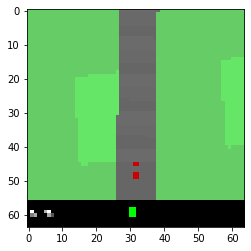

In [12]:
plt.imshow(obs)

In [13]:
vae_encoded_obs = model.update(obs, 0)

In [14]:
vae_encoded_obs

array([ 2.9186,  0.553 ,  1.3733, -0.4192, -0.9001, -1.1337, -0.0313,
       -0.3956,  0.2703,  0.0048,  0.5137, -0.0884,  1.6926, -0.1182,
        0.1103,  0.2099, -0.2856,  0.2983, -0.5186, -0.7534, -1.8401,
        1.0913, -1.0413, -0.9407, -1.4562, -0.7497,  1.1422,  0.0804,
       -0.7697, -0.7524,  1.0792, -0.0209], dtype=float32)

In [15]:
recon = model.vae.decoder.predict(np.array([vae_encoded_obs]))[0]

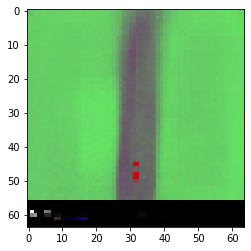

In [16]:
plt.imshow(recon)

In [17]:
# obs = obs_file[0]
!pip install pyvirtualdisplay
!pip install Pillow
from pyvirtualdisplay import Display as d
display2 = d(visible=0, size=(1400, 900))
display2.start()

action = [0,1,0]
reward = 0
model.reset()
total_reward = 0
total_pseudo_reward = 0
t = 0

obs = model.env.reset()

model.env.render('rgb_array')

actions0 = []
actions1 = []
actions2 = []

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


KeyboardInterrupt: 

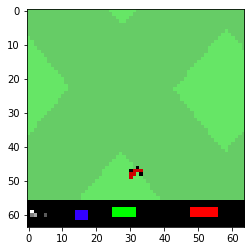

In [18]:
while (1):
   
    ######

    obs = config.adjust_obs(obs)
    reward = config.adjust_reward(reward)
    
    total_pseudo_reward+= reward

    vae_encoded_obs = model.update(obs, 0)

    recon = model.vae.decoder.predict(np.array([vae_encoded_obs]))[0]
    
#     input_to_rnn = [np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]),np.zeros(shape=(1,256)),np.zeros(shape=(1,256))]
#     input_to_rnn = [np.array([[np.concatenate([np.zeros(32), action, [reward]])]]),np.array([model.hidden]),np.array([model.cell_values])]


    input_to_rnn = [np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]),np.array([model.hidden]),np.array([model.cell_values])]

    #     print(np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]).shape)
    #     print(np.array([model.hidden]).shape)
    #     print(np.array([model.cell_values]).shape)

    out = model.rnn.forward.predict(input_to_rnn)

    y_pred = out[0][0][0]
    h = out[1][0]
    c = out[2][0]

    model.hidden = h
    model.cell_values = c

    next_z, next_reward, chosen_mu = get_z_from_rnn_output(y_pred)

    recon_next_z = model.vae.decoder.predict(np.array([next_z]))[0]

    controller_obs = np.concatenate([vae_encoded_obs,model.hidden])
    action = model.get_action(controller_obs, t=0, add_noise=0)
    #     actions0.append(action[0])
    #     actions1.append(action[1])
    #     actions2.append(action[2])

    #     action = model.activations(action)
#     action = [1,1,0]
    obs, reward, done, _ = model.env.step(action)
    
    total_reward+= reward


    plt.gca().cla() 
    plt.imshow( obs)

    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    
    print(total_reward)
    print(total_pseudo_reward)
    print(t)
    print(action)
    t += 1


    #     print(action)